In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import gm2
import trfp
import plotting_functions as plt2
import helper_functions as helper

import field_map_config_run1 as map_config

Welcome to JupyROOT 6.22/02


In [2]:
bloch_dict = {'run_1a1': '/data2/scharity/Run1/FinalUnblindingOct2020/60Hr_3956-3997_for_alec.csv',
              'run_1b1': '/data2/scharity/Run1/FinalUnblindingOct2020/HighKick_4058-4098_for_alec.csv',
              'run_1b2': '/data2/scharity/Run1/FinalUnblindingOct2020/HighKick_4098-4138_for_alec.csv',
              'run_1c1': '/data2/scharity/Run1/FinalUnblindingOct2020/9day_4138-4181_for_alec.csv',
              'run_1c2': '/data2/scharity/Run1/FinalUnblindingOct2020/9day_4189-4226_for_alec.csv',
              'run_1c3': '/data2/scharity/Run1/FinalUnblindingOct2020/9day_4226-4265_for_alec.csv',
              'run_1d2': '/data2/scharity/Run1/FinalUnblindingOct2020/endgame_5054-5103_for_alec.csv',
              'run_1d3': '/data2/scharity/Run1/FinalUnblindingOct2020/endgame_5117-5157_for_alec.csv',
              'run_1d4': '/data2/scharity/Run1/FinalUnblindingOct2020/endgame_5169-5217_for_alec.csv',
              'run_1d5': '/data2/scharity/Run1/FinalUnblindingOct2020/endgame_5217-5259_for_alec.csv',
              'run_1d6': '/data2/scharity/Run1/FinalUnblindingOct2020/endgame_5259-5303_for_alec.csv'}

In [13]:
mean_diffs = np.empty([11,4])

i = 0
for run in bloch_dict:

    bloch_df = pd.read_csv(bloch_dict[run], index_col=0)
    hybrid_raw_df = pd.read_hdf('/data2/aetb/2020-09-30_hybrid_maps.h5', key=run)

    bloch_df.index = np.round(bloch_df.index, -2)

    hybrid_azi_df = pd.DataFrame(index=hybrid_raw_df.index)

    weight = trfp.STATION_BARCODE_EDGES[1:] - trfp.STATION_BARCODE_EDGES[:-1]
    weight[2] = weight[2] + 360

    for m in range(9):
        stms = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
        hybrid_azi_df['m'+str(m+1)] = hybrid_raw_df[stms].dot(weight)/360

    first = np.ceil(hybrid_azi_df.index.values[0]/1000)*1000
    last = np.floor(hybrid_azi_df.index.values[-1]/1000)*1000

    intervals = np.arange(first, last+1000, 1000)
    centers = (intervals[:-1] + intervals[1:])/2

    hybrid_df = hybrid_azi_df.groupby(pd.cut(hybrid_azi_df.index.values, intervals)).mean()

    hybrid_df.index = list(centers)
    bloch_df = bloch_df.loc[centers]
    
    mean_diffs[i, 0] = np.mean(hybrid_df['m1']/61.79-bloch_df['dipole'])
    mean_diffs[i, 1] = np.mean(hybrid_df['m2']/61.79-bloch_df['nq'])
    mean_diffs[i, 2] = np.mean(hybrid_df['m3']/61.79-bloch_df['ns'])
    mean_diffs[i, 3] = np.mean(hybrid_df['m5']/61.79-bloch_df['sq'])
    i = i + 1

In [14]:
print np.round(mean_diffs*1000)

[[  4. -30.  -6. -12.]
 [ -2.  -5.   2.  -7.]
 [-29.  -9.   2.  -4.]
 [-37.   4.   3. -12.]
 [-13. -10.  -9.  -3.]
 [ 10.  -2.  -2.  -1.]
 [ -4.   5.  -2.  -5.]
 [ 21.  -5.   2.   2.]
 [-28.  10.  -4. -13.]
 [-15.  10.   2. -11.]
 [-12.  -2.  -2. -12.]]


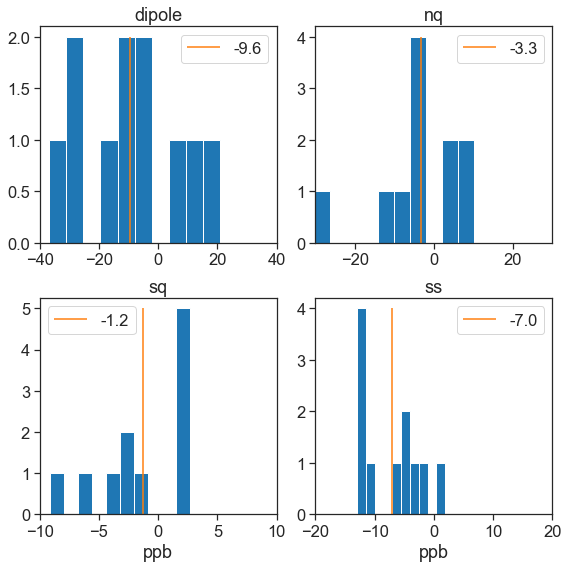

In [43]:
fig, axs = plt.subplots(2,2)

axs[0,0].hist(mean_diffs[:,0]*1000)
axs[0,0].set_xlim(-40,40)
axs[0,0].vlines(np.mean(mean_diffs[:,0]*1000),0,2,color='C1',label=np.round(np.mean(mean_diffs[:,0]*1000), 1))
axs[0,0].legend()
axs[0,0].set_title('dipole')

axs[0,1].hist(mean_diffs[:,1]*1000)
axs[0,1].set_xlim(-30,30)
axs[0,1].vlines(np.mean(mean_diffs[:,1]*1000),0,4,color='C1',label=np.round(np.mean(mean_diffs[:,1]*1000), 1))
axs[0,1].legend()
axs[0,1].set_title('nq')

axs[1,0].hist(mean_diffs[:,2]*1000)
axs[1,0].set_xlim(-10,10)
axs[1,0].vlines(np.mean(mean_diffs[:,2]*1000),0,5,color='C1',label=np.round(np.mean(mean_diffs[:,2]*1000), 1))
axs[1,0].legend()
axs[1,0].set_xlabel('ppb')
axs[1,0].set_title('sq')

axs[1,1].hist(mean_diffs[:,3]*1000)
axs[1,1].set_xlim(-20,20)
axs[1,1].vlines(np.mean(mean_diffs[:,3]*1000),0,4,color='C1',label=np.round(np.mean(mean_diffs[:,3]*1000), 1))
axs[1,1].legend()
axs[1,1].set_xlabel('ppb')
axs[1,1].set_title('ss')

fig.set_size_inches(8,8)
fig.tight_layout()

In [16]:
run = 'run_1d6'

bloch_df = pd.read_csv(bloch_dict[run], index_col=0)
hybrid_raw_df = pd.read_hdf('/data2/aetb/2020-09-30_hybrid_maps.h5', key=run)

bloch_df.index = np.round(bloch_df.index, -2)

hybrid_azi_df = pd.DataFrame(index=hybrid_raw_df.index)

weight = trfp.STATION_BARCODE_EDGES[1:] - trfp.STATION_BARCODE_EDGES[:-1]
weight[2] = weight[2] + 360

for m in range(9):
    stms = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
    hybrid_azi_df['m'+str(m+1)] = hybrid_raw_df[stms].dot(weight)/360

first = np.ceil(hybrid_azi_df.index.values[0]/1000)*1000
last = np.floor(hybrid_azi_df.index.values[-1]/1000)*1000

intervals = np.arange(first, last+1000, 1000)
centers = (intervals[:-1] + intervals[1:])/2

hybrid_df = hybrid_azi_df.groupby(pd.cut(hybrid_azi_df.index.values, intervals)).mean()

hybrid_df.index = list(centers)
bloch_df = bloch_df.loc[centers]


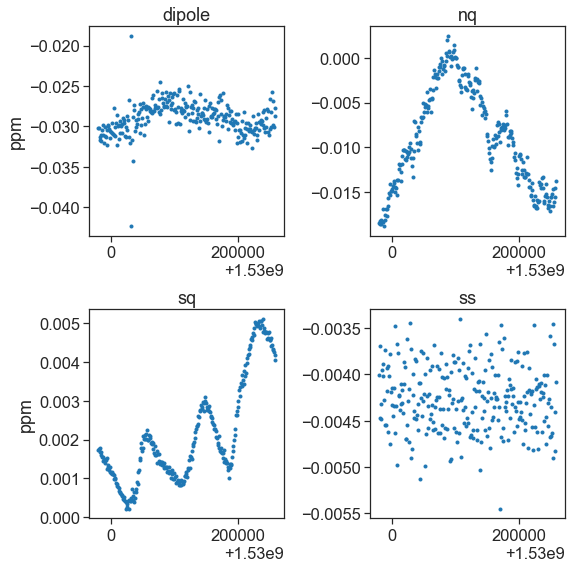

In [17]:
fig, axs = plt.subplots(2,2)

axs[0,0].plot(hybrid_df['m1']/61.79-bloch_df['dipole'], '.')
axs[0,0].set_title('dipole')
axs[0,0].set_ylabel('ppm')
axs[0,1].plot(hybrid_df['m2']/61.79-bloch_df['nq'], '.')
axs[0,1].set_title('nq')
axs[1,0].plot(hybrid_df['m3']/61.79-bloch_df['ns'], '.')
axs[1,0].set_title('sq')
axs[1,0].set_ylabel('ppm')
axs[1,1].plot(hybrid_df['m5']/61.79-bloch_df['sq'], '.')
axs[1,1].set_title('ss')

fig.set_size_inches(8,8)
fig.tight_layout()